In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
import us

## Get Police Shooting Data
Source: [Washington Post](https://github.com/washingtonpost/data-police-shootings)

In [2]:
url = 'https://raw.githubusercontent.com/washingtonpost/data-police-shootings/master/fatal-police-shootings-data.csv'
raw_data = pd.read_csv(url, index_col=0)
print(f'Record Count: {len(raw_data)}')

Record Count: 5587


In [3]:
df = raw_data.copy().reset_index(drop=True)
df.date = df.date.apply(lambda x: dt.strptime(x, '%Y-%m-%d'))
df.state = df.state.apply(lambda x: us.states.lookup(x).name)
df = df.rename(columns={'state':'Location'}).set_index('Location')

races_dict = {'W': 'White', 'B':'Black', 'H':'Hispanic', 'A':'Asian', 'N':'Native American', 'O':'Other'}
df.race = df.race.fillna('O')
df.race = df.race.apply(lambda x: races_dict[x])
df.head()

,name,date,manner_of_death,armed,age,gender,race,city,signs_of_mental_illness,threat_level,flee,body_camera
Location,,,,,,,,,,,,
Washington,Tim Elliot,2015-01-02,shot,gun,53.0,M,Asian,Shelton,True,attack,Not fleeing,False
Oregon,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,White,Aloha,False,attack,Not fleeing,False
Kansas,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,Hispanic,Wichita,False,other,Not fleeing,False
California,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,White,San Francisco,True,attack,Not fleeing,False
Colorado,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,Hispanic,Evans,False,attack,Not fleeing,False


## Get Population Demographics
Source: US Census Data via [Kaiser Family Foundation](https://www.kff.org/other/state-indicator/distribution-by-raceethnicity/?currentTimeframe=0&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D)

Demographics based on 2018 data by state to approximate average population makeup from 2015-2020.

In [4]:
demo = pd.read_csv('kff_demographics.csv', skiprows=[0, 1, 3], nrows=51, usecols=range(0,8))
demo.head()

,Location,White,Black,Hispanic,American Indian/Alaska Native,Asian,Native Hawaiian/Other Pacific Islander,Two Or More Races
0,Alabama,0.66,0.26,0.04,<.01,0.01,NaN,0.02
1,Alaska,0.60,0.03,0.07,0.16,0.06,0.01,0.07
2,Arizona,0.54,0.04,0.32,0.04,0.03,<.01,0.02
3,Arkansas,0.72,0.15,0.08,0.01,0.02,<.01,0.03
4,California,0.37,0.05,0.39,<.01,0.15,<.01,0.03


In [5]:
# Remove null values and convert data to numeric
for col in demo.columns[1:-1]:
    if demo[col].dtype=='object':
        demo[col] = demo[col].apply(lambda x: str(x).replace('<.01', '.005'))
        demo[col] = demo[col].astype('float64')
        demo[col] = demo[col].fillna(0)

# Join all Natives/Pacific Islanders into single group
demo['Native American'] = demo['American Indian/Alaska Native'] + demo['Native Hawaiian/Other Pacific Islander']
demo = demo.drop(['American Indian/Alaska Native', 'Native Hawaiian/Other Pacific Islander'], axis=1)

# Organize and clean other column labels
demo = demo.rename(columns={'Two Or More Races': 'Other'})
demo = demo[['Location', 'White', 'Black', 'Hispanic', 'Asian', 'Native American', 'Other']]
demo.head()

,Location,White,Black,Hispanic,Asian,Native American,Other
0,Alabama,0.66,0.26,0.04,0.01,0.005,0.02
1,Alaska,0.60,0.03,0.07,0.06,0.170,0.07
2,Arizona,0.54,0.04,0.32,0.03,0.045,0.02
3,Arkansas,0.72,0.15,0.08,0.02,0.015,0.03
4,California,0.37,0.05,0.39,0.15,0.010,0.03


### Get Population Totals
Source: [Census.gov](https://www.census.gov/newsroom/press-kits/2019/national-state-estimates.html)

In [6]:
# Get Normalized Population Data
pop = pd.read_csv('nst-est2019-01.csv', index_col=0, skiprows=[0]).reset_index()
pop = pop.rename(columns={'index':'Location', '2018':'Population'})
pop['Location'] = pop['Location'].apply(lambda x: x.replace('.', ''))

# Represent Population Counts as Percentages
national_pop = pop.Population.sum()
pop.Population = pop.Population / national_pop

# Join to population demographics
demo = demo.set_index('Location').join(pop.set_index('Location'))
demo.head()

,White,Black,Hispanic,Asian,Native American,Other,Population
Location,,,,,,,
Alabama,0.66,0.26,0.04,0.01,0.005,0.02,0.014961
Alaska,0.60,0.03,0.07,0.06,0.170,0.07,0.002250
Arizona,0.54,0.04,0.32,0.03,0.045,0.02,0.021911
Arkansas,0.72,0.15,0.08,0.02,0.015,0.03,0.009213
California,0.37,0.05,0.39,0.15,0.010,0.03,0.120793


In [7]:
# Represent all percentages as percentage of national population
for col in demo.columns[:-1]:
    demo[col] = demo[col] * demo['Population']

# Combine all data to get national representation & Save to Dataframe
demo.loc['Population Distribution']= demo.sum()
demo_df = pd.DataFrame(demo.loc['Population Distribution'][:-1])
demo_df = demo_df.reset_index().rename(columns={'index':'Race'}).set_index('Race')
demo_df

,Population Distribution
Race,
White,0.603647
Black,0.121716
Hispanic,0.182672
Asian,0.057477
Native American,0.012297
Other,0.027255


In [8]:
# Get racial distributions for shootings in various scenarios
all_shootings = pd.DataFrame(df.race.value_counts(normalize=True))
all_shootings = all_shootings.rename(columns={'race':'All Shootings'})

no_gun = pd.DataFrame(df[df.armed!='gun'].race.value_counts(normalize=True))
no_gun = no_gun.rename(columns={'race':'No Gun'})

unarmed = pd.DataFrame(df[df.armed=='unarmed'].race.value_counts(normalize=True))
unarmed = unarmed.rename(columns={'race':'Unarmed'})

high_threat = pd.DataFrame(df[df.threat_level=='attack'].race.value_counts(normalize=True))
high_threat = high_threat.rename(columns={'race':'High Threat'})

low_threat = pd.DataFrame(df[df.threat_level!='attack'].race.value_counts(normalize=True))
low_threat = low_threat.rename(columns={'race':'Low Threat'})

# Combine all results into single dataframe
results = demo_df.join(all_shootings).join(no_gun).join(unarmed).join(high_threat).join(low_threat)
results = results[:5]*100
results = results.reset_index()
results

,Race,Population Distribution,All Shootings,No Gun,Unarmed,High Threat,Low Threat
0,White,60.364685,45.247897,43.093466,41.011236,46.266593,43.378995
1,Black,12.171587,23.590478,22.580645,35.112360,24.446903,22.019280
2,Hispanic,18.267208,16.466798,19.023987,17.696629,14.767699,19.583968
3,Asian,5.747743,1.664578,2.357320,1.966292,1.410398,2.130898
4,Native American,1.229741,1.396098,1.530190,1.123596,1.216814,1.725013


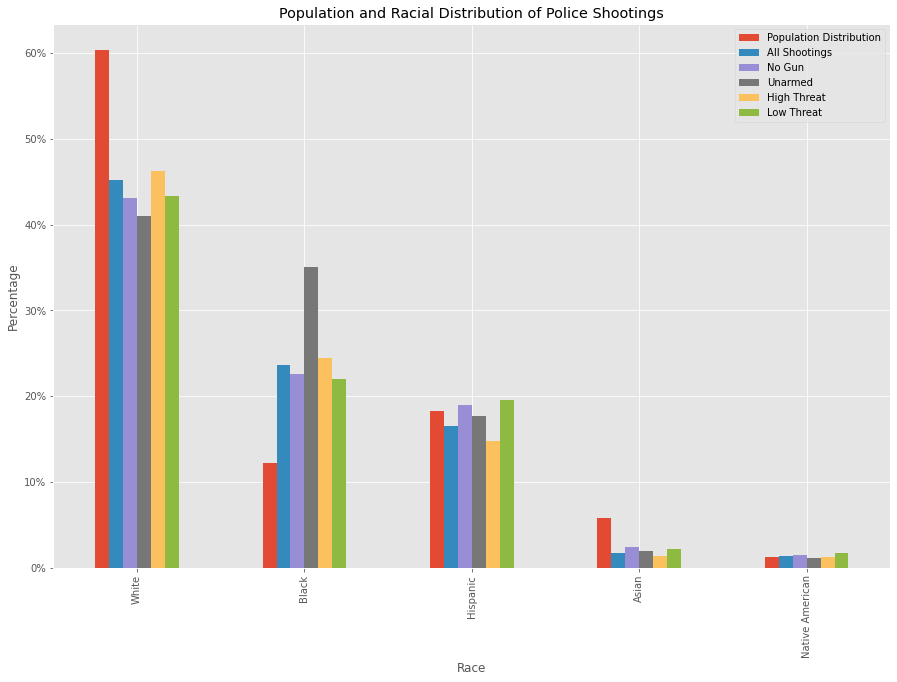

In [9]:
# Display results
plt.style.use('ggplot')
results.plot(x='Race', y=results.columns[1:], kind='bar', figsize=(15, 10))
plt.title('Population and Racial Distribution of Police Shootings')
plt.ylabel('Percentage')

y_ticks = list(range(0, 61, 10))
y_labels = [f'{str(tick)}%' for tick in y_ticks]
plt.yticks(y_ticks, y_labels)
plt.show()